# Testing the 'Flow Matching in 100 LOC'-code and augmenting it with Bayesian Methods

In [1]:
import torch
import torch.nn as nn
from torch import Tensor
from torch.distributions import Normal

import sys
sys.path.append('./src/')
sys.path.append('./src/models/')

from cond_CFM import CNF, FlowMatchingLoss

sys.path.append('../MCMC_by_backprob/src/')
from MCMC_Adam import MCMC_by_bp

import numpy as np
import normflows as nf
import os
from tqdm import tqdm
from typing import *
from zuko.utils import odeint
from scipy.special import kl_div
from scipy.stats import wasserstein_distance

from models.custom_linear_flipout import custom_LinearFlipout as LinearFlipout, Flipout_Dropout, LinearDropout
from bayesian_torch.layers.dropout import Dropout
from bayesian_torch.layers.batchnorm import BatchNorm1dLayer

from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import pickle

In [2]:
from src.utils import *
from src.dataloader import *
from src.plot_util import *

In [3]:
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

In [4]:
def mkdir(save_dir):
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)
    return save_dir

def smooth(x, kernel_size=5):
    if kernel_size == 1:
        return x
    else:
        assert kernel_size % 2 != 0
        x_shape = x.shape
        x_tmp = np.array([x[i:x_shape[0]-kernel_size+i+1] for i in range(kernel_size)])
        edge1 = x[:int((kernel_size-1)/2)]
        edge2 = x[-int((kernel_size-1)/2):]
        x_out = np.concatenate((edge1, np.mean(x_tmp, 0),edge2),0)
        assert x_shape == x_out.shape
        return x_out #np.mean(np.array(x).reshape(-1, kernel_size),1)

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [6]:
approximate_gaussian_inference = True
MCMC = approximate_gaussian_inference == False

train = False
train_MCMC = False

assert MCMC != approximate_gaussian_inference; "choose either MCMC- or VI-Bayesian"

c_factor = 10.

if approximate_gaussian_inference:
    save_dir = mkdir(f'./models/CFM_VIB_k{c_factor}_cond')
else:
    save_dir = mkdir('./models/CFM_cond/')

In [7]:
#######################
### Define the data ###
#######################

from dataloader import *
from torch.utils.data import Dataset

class cond_dataset(Dataset):
    def __init__(self, x, c):
        super(Dataset, self).__init__()
        self.x = x
        self.c = c

    def __len__(self):
        return len(self.x)

    def __getitem__(self, index):
        return self.x[index], self.c[index]

add_str_save = ''
data_dim = 2 #5
save_as_try = 0
n_samples = 10_000
donut_shape = "donut_gamma"

data_path = './data/' 

donut_args = {'u_mean':0, 'u_sigma':1, 'r_mean': 4., 'r_sigma': 1, 'm_cut': 'inf', 'gamma_scale': 2.}
#save_dir = mkdir(mkdir(save_dir + f'/donut_{data_dim}d{add_str_save}_{donut_args["m_cut"]}m_cut/')+f'{n_samples}pts/')
save_dir = mkdir(mkdir(mkdir(save_dir + f'/{donut_shape}_{data_dim}d{add_str_save}_{donut_args["r_mean"]}rmean_{donut_args["gamma_scale"]}gamma/')+f'{n_samples}pts/')+f'{save_as_try}/')

sampler = multidim_sampler(data_dim, donut_shape, save_path = data_path, **donut_args)

full_data = sampler.sample_data(n_samples, save_as_try = save_as_try)
test_data = sampler.sample_data(n_samples//10)
full_dataset = cond_dataset(full_data[0], full_data[1])
test_dataset = cond_dataset(test_data[0], test_data[1])

n_batches = 10
batch_size = n_samples//n_batches
dataloader = torch.utils.data.DataLoader(full_dataset, batch_size=batch_size, shuffle=True, num_workers=10, pin_memory=True, persistent_workers=True)
dataloader_test = torch.utils.data.DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=True, num_workers=10, pin_memory=True, persistent_workers=True)

bins=np.linspace(-7,7,50)
H,_,_ =  np.histogram2d(test_data[0][:,0], test_data[0][:,1], bins=bins)

Text(0, 0.5, 'occurence')

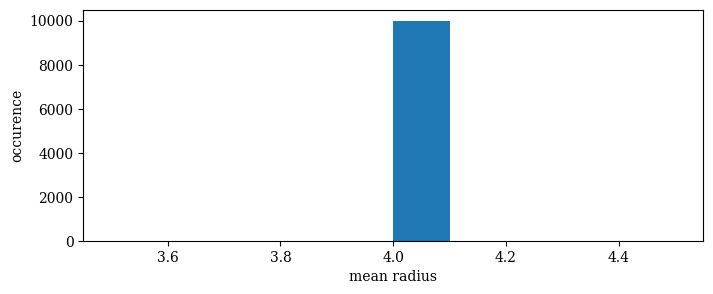

In [8]:
plt.figure(figsize=(8,3))

plt.hist(full_data[1])
#plt.yscale('log')
plt.xlabel('mean radius')
plt.ylabel('occurence')

/beegfs/desy/user/bierings/Bayesiamplify/./src/dataloader.py:7: RuntimeWarning: divide by zero encountered in divide
  out = np.arctan(1/x)


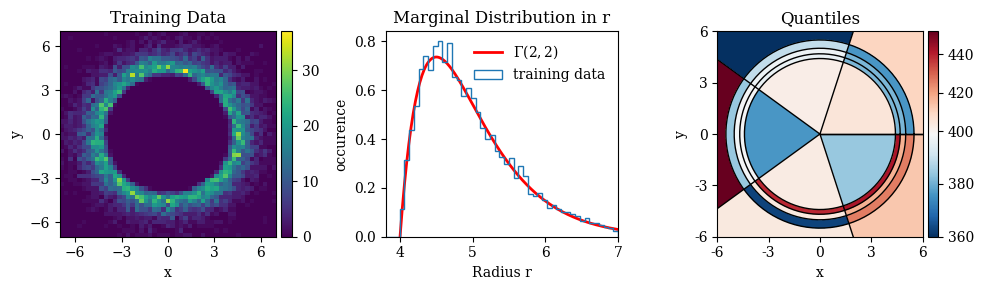

In [24]:
#fig,ax = plt.subplots(1,1,figsize=(3.3,3))
fig_quantiles,ax_quantiles = plt.subplots(1,3,figsize=(10,3))

bins =np.linspace(-7,7,50)
_,_,_,hist = ax_quantiles[0].hist2d(full_data[0][:,0], full_data[0][:,1], bins = bins)
#plt.title('overlap' if donut_args['r_mean'] == 'triag' else f'r = {donut_args["r_mean"]}')
divider = make_axes_locatable(ax_quantiles[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(hist, cax=cax)
ax_quantiles[0].set_title('Training Data')
ax_quantiles[0].set_xlabel('x')
ax_quantiles[0].set_ylabel('y')

ax_quantiles[0].set_xticks([-6,-3,0,3,6])
ax_quantiles[0].set_yticks([-6,-3,0,3,6])

#fig.tight_layout()
#plt.savefig('./figs/01_1_ring_data.pdf')

##############################################################################################################################################################################################

#plt.figure(figsize=(3.2,3))

import scipy.special as sps
x = np.linspace(4,7,200)
shape = 2
scale = 1/shape
x = x -4  
y = x**(shape-1)*(np.exp(-x/scale) /  
                     (sps.gamma(shape)*scale**shape))
ax_quantiles[1].plot(x+4, y, linewidth=2, color='r', label = r"$\Gamma(2,2)$")  

_ = ax_quantiles[1].hist(cart_to_nsphere(full_data[0])[:,0], bins = np.linspace(3.8,7,50), histtype = 'step', density=True, label = 'training data')
ax_quantiles[1].set_title('Marginal Distribution in r')
ax_quantiles[1].set_xlabel('Radius r')
ax_quantiles[1].set_ylabel('occurence')
ax_quantiles[1].set_xlim(3.8,7)

ax_quantiles[1].legend(frameon=False)
#plt.tight_layout()
#plt.savefig('./figs/01_2_radius_data.pdf')

##############################################################################################################################################################################################

import matplotlib.colors as clr

n_quantile = 5
data_true = cart_to_nsphere(sampler.sample_data(10_000_000)[0])
quant_list = quantiles(data_true, n_quantile, verbose = False)
quant_list = (np.concatenate((np.asarray([-100]), np.asarray(quant_list[0]), np.asarray([100])), 0),
            np.concatenate((np.asarray([0]), np.asarray(quant_list[1]), np.asarray([2*np.pi])), 0))

#font_s = None 
bins_data = quant_list

data_true = cart_to_nsphere(full_data[0])
quantvals_true = quantile_values_via_hist(quant_list, data_true)*len(data_true)

number_pixels = 800 #2000 increase for final plots

img_data = np.zeros((number_pixels, number_pixels))

E_min = -6 #2*r_test
E_max = 6 #2*r_test

for x in range(0, number_pixels):
    for y in range(0, number_pixels):
        X = ((x + 0.0)*(E_max-E_min))/number_pixels+E_min
        Y = ((y + 0.0)*(E_max-E_min))/number_pixels+E_min
        r  = np.sqrt(X**2 + Y**2)
        phi = np.arctan2(X,Y) #+ np.pi
        phi = phi + 2*np.pi*(phi<0).astype(int)
                
        hist_data_temp = np.array([[r,phi]])
        quant_hist_temp, edges = np.histogramdd(sample = hist_data_temp, bins = bins_data, range = None)

        img_data[x,y] = np.sum(quant_hist_temp*np.abs(quantvals_true))

quantile_sample_img_data = np.copy(img_data)

divnorm = clr.TwoSlopeNorm(vmin=quantile_sample_img_data.min(), vcenter=quantile_sample_img_data.mean(), vmax=quantile_sample_img_data.max())
col_map = clr.LinearSegmentedColormap.from_list('col_map',  plt.cm.RdBu(np.linspace(1, 0, 256)))

#figSide = plt.figure(figsize=(3.5,3))
axS1 = ax_quantiles[2] #figSide.add_subplot(1,1,1)
pStra = axS1.imshow(quantile_sample_img_data, norm=divnorm, cmap=col_map)

axS1.set_xticks(np.arange(0, number_pixels+1, number_pixels/4))
axS1.set_xticklabels([f'{n:.0f}' for n in np.around(np.linspace(E_min, E_max, 5),2)])
axS1.set_yticks(np.arange(0, number_pixels+1, number_pixels/4))
axS1.set_yticklabels([f'{n:.0f}' for n in np.around(np.linspace(E_min, E_max, 5),2)])
#axS1.tick_params(labelsize=font_s) 

divider = make_axes_locatable(axS1)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(pStra, cax=cax)#, ticks = [0.1,0.5,1,1.5,2.0])
#cax.tick_params(labelsize=font_s) 

for r in quant_list[0]:
    a = np.linspace(0, 2*np.pi, 100)
    x = r*np.cos(a)*number_pixels/(E_max-E_min) + number_pixels/2
    y = r*np.sin(a)*number_pixels/(E_max-E_min) + number_pixels/2
    axS1.plot(x,y, color='k', linewidth = 1.)

for p in quant_list[1]:
    r = np.linspace(0, 20, 20)
    x = r*np.cos(p)*number_pixels/(E_max-E_min) + number_pixels/2
    y = r*np.sin(p)*number_pixels/(E_max-E_min) + number_pixels/2
    axS1.plot(x,y, color='k', linewidth = 1.)   

# x = -r*np.cos(np.pi)*number_pixels/(E_max-E_min) + number_pixels/2
# y = r*np.sin(np.pi)*number_pixels/(E_max-E_min) + number_pixels/2
# axS1.plot(x,y, color='k', label='quantiles', linewidth = 1.)   

axS1.set_xlim([0, number_pixels])
axS1.set_ylim([0, number_pixels])

#axS1.legend()
axS1.set_xlabel('x')
axS1.set_ylabel('y')
axS1.set_title("Quantiles")
#plt.subplots_adjust(left=0.1, right=0.88, top=0.96, bottom=0.10)
fig_quantiles.tight_layout()

#img_outfile = f"./figs/01_3_image_ep{ep}_sigma_radial.pdf"
#plt.savefig(img_outfile)

img_outfile = f"./figs/01_data_and_quantiles.pdf"
fig_quantiles.savefig(img_outfile)

Text(0.5, 0, 'y')

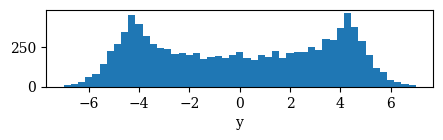

In [9]:
plt.figure(figsize=(5,1))
_ = plt.hist(full_data[0][:,0], bins = bins)
plt.xlabel('y')

In [10]:
########################
### Define the Model ###
########################
p = 0
n_nodes = 32
n_layers = 3

if approximate_gaussian_inference:
    if p != 0:
        model = CNF(data_dim, conds = 1, hidden_features=[n_nodes] * n_layers, layer = Flipout_Dropout, layer_kwargs={'p': p})
    else:
        model = CNF(data_dim, conds = 1, hidden_features=[n_nodes] * n_layers, layer = LinearFlipout)

else:
    if p != 0:
        model = CNF(data_dim, conds = 1, hidden_features=[n_nodes] * n_layers, layer = LinearDropout,  layer_kwargs={'p': p})
    else:
        model = CNF(data_dim, conds = 1, hidden_features=[n_nodes] * n_layers)
        
model.to(device)

for layer in model.modules():
    if isinstance(layer, LinearFlipout):
        layer._dnn_to_bnn_flag = True
        layer.auto_sample = False 

print(f"initiated model with {sum(p.numel() for p in model.parameters())} parameters")

initiated model with 4996 parameters


In [11]:
#####################
### Training Loop ###
#####################

lr = 1e-3
lr_decay = 1#0.9995
weight_decay = 0

epochs = 2501 if MCMC else 250001#20000
ep_start = 0 #0

if train:
    cfm_loss = FlowMatchingLoss(model)
    optim = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.99,0.99)) #torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, lr_decay)
    model.train()

    if ep_start == 0:
        loss_hist, loss_hist_KLD, loss_hist_test, loss_hist_test_ep, nlog_likl_hist, kl_div_hist, w1_hist = np.array([]), np.array([]), np.array([]), np.array([]), np.array([]),  np.array([]),  np.array([])

    for ep in tqdm(range(ep_start, ep_start+epochs)):
        optim.zero_grad()
        
        for x,c in dataloader:
            optim.zero_grad()
            x,c = x.to(device), c.to(device)
            
            for layer in model.modules():
                if hasattr(layer, 'sample_weights'):
                    layer.sample_weights()

            # Compute loss
            loss_orig = cfm_loss(x, c)
            kl_loss = torch.nan_to_num(torch.sum(torch.tensor([layer.kl_loss() for layer in model.modules() 
                                                                if isinstance(layer, LinearFlipout)], requires_grad=True))/len(x))
            
            loss = loss_orig + c_factor*kl_loss
            
            # Do backprop and optimizer step
            if ~(torch.isnan(loss) | torch.isinf(loss)):
                loss.backward()
                optim.step()
                scheduler.step()


        # Log loss
        loss_hist = np.append(loss_hist, loss_orig.to('cpu').data.numpy())
        loss_hist_KLD = np.append(loss_hist_KLD, kl_loss.to('cpu').data.numpy())

        if ep%100 == 0:
            loss_test, nlog_likl = torch.Tensor([0]).to('cpu'), torch.Tensor([0]).to('cpu')
            for x, c in dataloader_test:
                x,c = x.to(device), c.to(device)
                loss_test += cfm_loss(x, c).to('cpu')*len(x)
                if MCMC:
                    nlog_likl -= torch.sum(model.log_prob(x,c)).to('cpu')
                
            z = torch.randn(len(c), data_dim).to(device)
            generated_data = model.decode(z, cond=c).detach().cpu().numpy()
            H_gen,_,_ =  np.histogram2d(generated_data[:,0], generated_data[:,1], bins=bins)
            w1 = wasserstein_distance(H.flatten(), H_gen.flatten())
            kl_div_test = np.sum(np.nan_to_num(kl_div(H, H_gen), 0, 0, 0))

            loss_hist_test = np.append(loss_hist_test, loss_test.to('cpu').data.numpy()/len(dataloader_test.dataset))
            loss_hist_test_ep= np.append(loss_hist_test_ep, ep)
            nlog_likl_hist = np.append(nlog_likl_hist, nlog_likl.to('cpu').data.numpy()/len(dataloader_test.dataset))
            kl_div_hist = np.append(kl_div_hist, kl_div_test)
            w1_hist = np.append(w1_hist, w1)

        if ep%5000 == 0:
            torch.save(model.state_dict(), save_dir + f"model_{ep}.pth")
            torch.save(optim.state_dict(), save_dir + f"optim_{ep}.pth")


    torch.save(model.state_dict(), save_dir + f"model_{ep}.pth")
    torch.save(optim.state_dict(), save_dir + f"optim_{ep}.pth")

    with open(save_dir + f'loss_hist_{ep}.npy', 'wb') as f:
        np.save(f, loss_hist)
    with open(save_dir + f'loss_hist_KLD_{ep}.npy', 'wb') as f:
        np.save(f, loss_hist_KLD)
    with open(save_dir + f'loss_hist_test_{ep}.npy', 'wb') as f:
        np.save(f, loss_hist_test)
    with open(save_dir + f'loss_hist_test_ep_{ep}.npy', 'wb') as f:
        np.save(f, loss_hist_test_ep)
    with open(save_dir + f'nlog_likl_hist_{ep}.npy', 'wb') as f:
        np.save(f, nlog_likl_hist)
    with open(save_dir + f'kl_div_hist_{ep}.npy', 'wb') as f:
        np.save(f, kl_div_hist)
    with open(save_dir + f'w1_hist_{ep}.npy', 'wb') as f:
        np.save(f, w1_hist)

    model.eval()

else:
    ep = epochs-1

    with open(save_dir + f'loss_hist_{ep}.npy', 'rb') as f:
        loss_hist = np.load(f)
    with open(save_dir + f'loss_hist_KLD_{ep}.npy', 'rb') as f:
        loss_hist_KLD =  np.load(f)
    with open(save_dir + f'loss_hist_test_{ep}.npy', 'rb') as f:
        loss_hist_test =  np.load(f)
    with open(save_dir + f'loss_hist_test_ep_{ep}.npy', 'rb') as f:
        loss_hist_test_ep =  np.load(f)
    with open(save_dir + f'nlog_likl_hist_{ep}.npy', 'rb') as f:
        nlog_likl_hist =  np.load(f)
    with open(save_dir + f'kl_div_hist_{ep}.npy', 'rb') as f:
        kl_div_hist =  np.load(f)
    with open(save_dir + f'w1_hist_{ep}.npy', 'rb') as f:
        w1_hist =  np.load(f)

    if approximate_gaussian_inference:
        if c_factor == 1.0:
            ep = 250000
        elif c_factor == 5.0:
            ep =200000
        elif c_factor == 10.0:
            ep = 180000
        elif c_factor == 50.:
            ep = 75000
        elif c_factor == 100.:
            ep = 40000

    model.load_state_dict(torch.load(save_dir + f"model_{ep}.pth"))
    print('loaded model from ' + save_dir + f"model_{ep}.pth")

    model.eval()

loaded model from ./models/CFM_VIB_k10.0_cond/donut_gamma_2d_4.0rmean_2.0gamma/10000pts/0/model_180000.pth


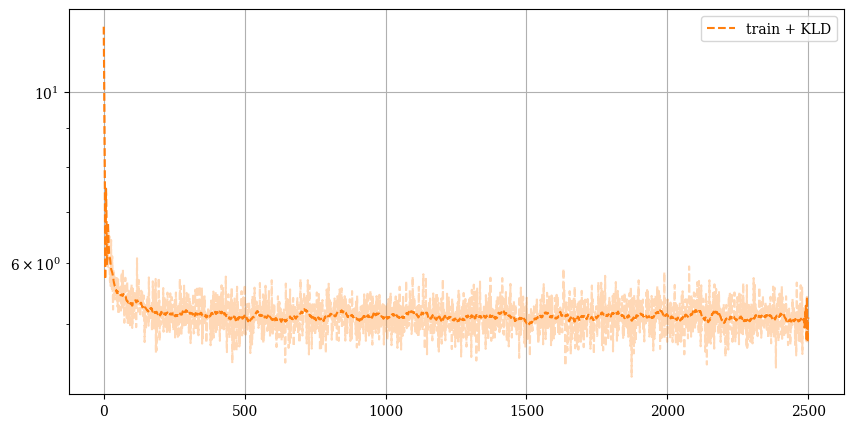

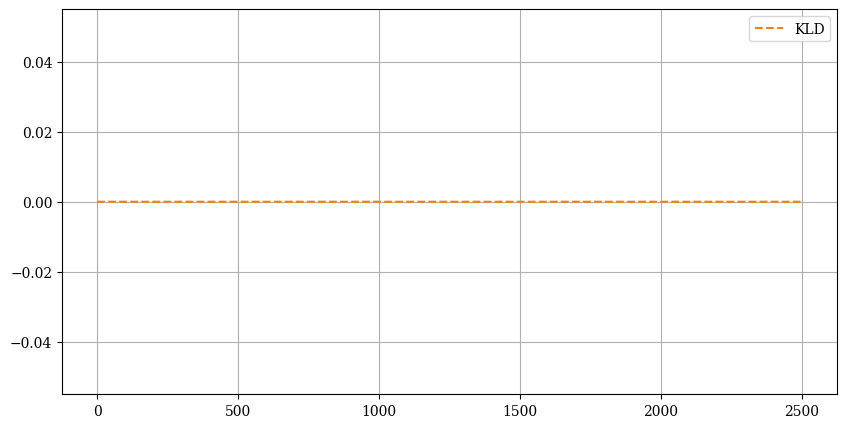

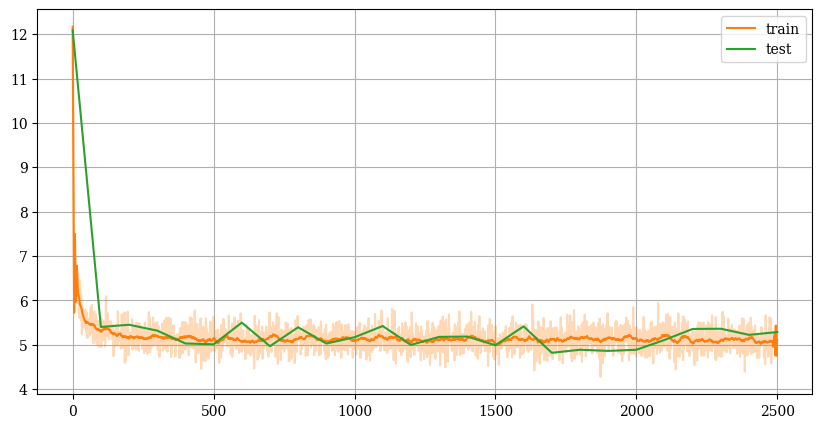

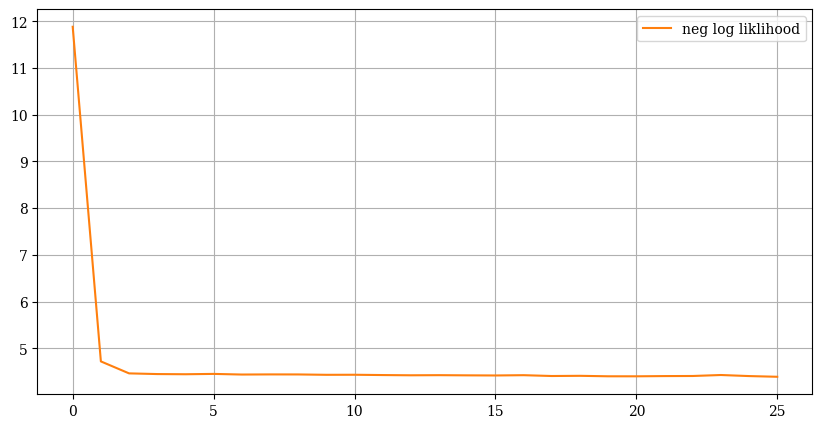

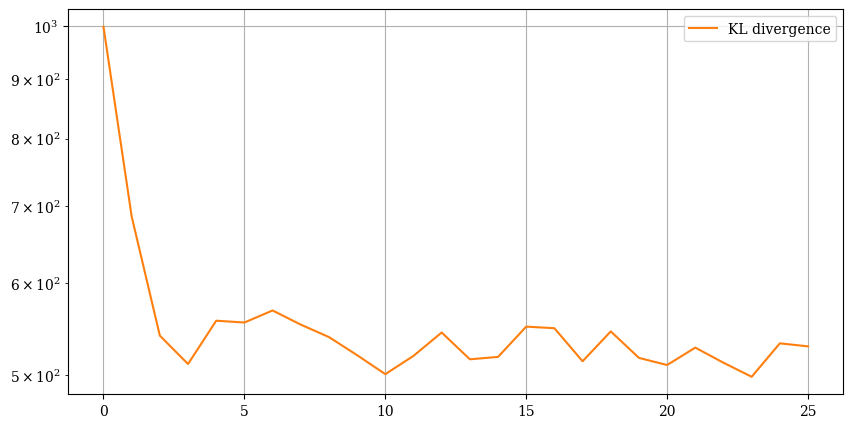

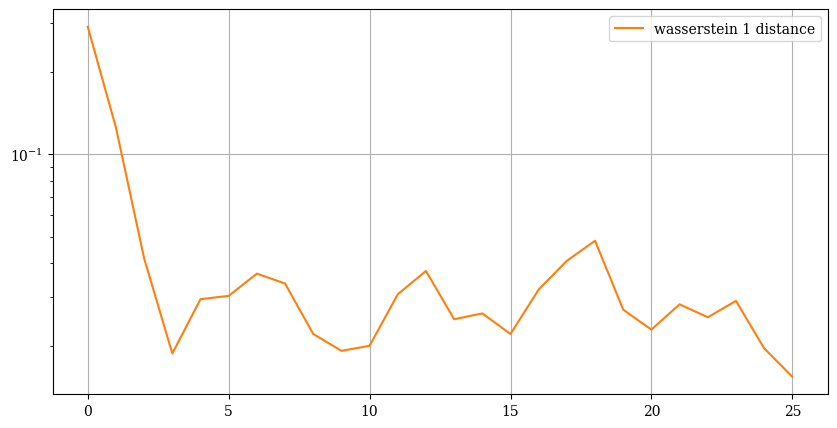

In [25]:
# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(smooth(loss_hist+c_factor*loss_hist_KLD,1), color = 'C1', linestyle = '--',alpha = 0.3)
plt.plot(smooth(loss_hist+c_factor*loss_hist_KLD,31), color = 'C1', linestyle = '--', label = 'train + KLD')
plt.grid()
plt.legend()
#plt.xlim(0,12500)
#plt.ylim(3,8)
plt.yscale('log')
img_outfile = save_dir + f"image_ep{ep}_loss_kld.pdf"
plt.savefig(img_outfile)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(smooth(loss_hist_KLD,1), color = 'C1', linestyle = '--',alpha = 0.3)
plt.plot(smooth(loss_hist_KLD,31), color = 'C1', linestyle = '--', label = 'KLD')
img_outfile = save_dir + f"image_ep{ep}_kld.pdf"
plt.savefig(img_outfile)
plt.grid()
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(smooth(loss_hist,1), color = 'C1', alpha = 0.3)
plt.plot(smooth(loss_hist,31), color = 'C1', label = 'train')
plt.plot(loss_hist_test_ep, loss_hist_test, color = 'C2', label = 'test')
plt.legend()
plt.grid()
img_outfile = save_dir + f"image_ep{ep}_loss.pdf"
plt.savefig(img_outfile)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(nlog_likl_hist, color = 'C1', label = 'neg log liklihood')
plt.grid()
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(kl_div_hist, color = 'C1', label = 'KL divergence')
plt.yscale('log')
plt.grid()
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(w1_hist, color = 'C1', label = 'wasserstein 1 distance')
plt.yscale('log')
plt.grid()
plt.legend()
plt.show()


In [26]:
if MCMC:
    save_every = 100
    MCMC_samples = 10
    m_list_dir =  mkdir(mkdir(save_dir ) + '/AdamMCMC_models/')

else:
    m_list_dir = save_dir


lr = 1e-3
lr_decay = 1#0.9995

temp = 1.0 #1.
sigma = .1
sigma_adam_dir_denom = 50.

if MCMC and train_MCMC:

    MCMC_epochs = save_every*MCMC_samples+1

    m_list_dir= mkdir(m_list_dir + f'{sigma}sigma_{temp}temp_{lr}lr_{sigma_adam_dir_denom}sigma_adam_dir_denom/')

    loop_kwargs = {
                'MH': True, #this is a little more than x2 runtime
                'verbose': MCMC_epochs<10,
                'fixed_batches': True,
                'sigma_adam_dir': sum(p.numel() for p in model.parameters())/sigma_adam_dir_denom if sigma_adam_dir_denom!=0 else 0,
                'extended_doc_dict': False,
                'full_loss': None,
    }

    optim = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.99,0.99))

    optim.load_state_dict(torch.load(save_dir + f"optim_{epochs-1}.pth"))
    model.load_state_dict(torch.load(save_dir + f"model_{epochs-1}.pth"))

    model.device = device

    AdamMCMC = MCMC_by_bp(model, optim, temp, sigma)

    scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, lr_decay)
    model.train()

    acc_hist, b_hist = np.array([]), np.array([])
    loss_hist, loss_hist_test, loss_hist_test_ep, kl_div_hist, w1_hist = np.array([]), np.array([]), np.array([]), np.array([]), np.array([])

    maxed_out_mbb_batches =0
    first = 0
    for ep in tqdm(range(MCMC_epochs)):        
        for x,c in dataloader:
            optim.zero_grad()
            x,c = x.to(device), c.to(device)
            
            # Compute log Likl
            loss = lambda: -torch.sum(model.log_prob(x, c))*n_samples/len(x)


            if first < 5:
                l = loss()
                l.backward()
                optim.step()
                scheduler.step()
                first += 1
            # Do backprop and optimizer step
            #t1= time()

            else:
                maxed_out_mbb_batches += 1
                _,a,b,sigma,stop_dict = AdamMCMC.step(loss, **loop_kwargs)
            #print(f't_update: {time()-t1:4.4} s')
            
                if b: 
                    maxed_out_mbb_batches  = 0
                if maxed_out_mbb_batches > 100:
                    print('MBB sampling is not convergent, reinitializing the chain')
                    AdamMCMC.start = True #This is a hot fix to not get the optimizer stuck to often

                scheduler.step()
                acc_hist = np.append(acc_hist, a.to('cpu').data.numpy())
                b_hist = np.append(b_hist, b)

        if ep%100 == 0:
            loss_test, nlog_likl = 0, 0
            for x,c in dataloader_test:
                x,c = x.to(device), c.to(device)
                loss_test -= torch.sum(model.log_prob(x, c))
                
            z = torch.randn(len(c), data_dim).to(device)
            generated_data = model.decode(z, cond=c).detach().cpu().numpy()
            H_gen,_,_ =  np.histogram2d(generated_data[:,0], generated_data[:,1], bins=bins)
            w1 = wasserstein_distance(H.flatten(), H_gen.flatten())
            kl_div_test = np.sum(np.nan_to_num(kl_div(H, H_gen), 0, 0, 0))

            loss_hist_test = np.append(loss_hist_test, loss_test.to('cpu').data.numpy()/len(dataloader_test.dataset))
            loss_hist_test_ep= np.append(loss_hist_test_ep, ep)
            kl_div_hist = np.append(kl_div_hist, kl_div_test)
            w1_hist = np.append(w1_hist, w1)
            
        # Log loss
        loss_hist = np.append(loss_hist, loss().to('cpu').data.numpy())

        if ep%save_every==0:
            torch.save(model.state_dict(), m_list_dir + f"AdamMCMC_model_{ep}.pth")

    with open(m_list_dir + f'AdamMCMC_losses_{ep}.npy', 'wb') as f:
        np.save(f, loss_hist)
    with open(m_list_dir + f'AdamMCMC_acc_{ep}.npy', 'wb') as f:
        np.save(f, acc_hist)
    with open(m_list_dir + f'loss_hist_{ep}.npy', 'wb') as f:
        np.save(f, loss_hist)
    with open(m_list_dir + f'loss_hist_test_{ep}.npy', 'wb') as f:
        np.save(f, loss_hist_test)
    with open(m_list_dir + f'loss_hist_test_ep_{ep}.npy', 'wb') as f:
        np.save(f, loss_hist_test_ep)
    with open(m_list_dir + f'kl_div_hist_{ep}.npy', 'wb') as f:
        np.save(f, kl_div_hist)
    with open(m_list_dir + f'w1_hist_{ep}.npy', 'wb') as f:
        np.save(f, w1_hist)

elif MCMC:
    m_list_dir= mkdir(m_list_dir + f'{sigma}sigma_{temp}temp_{lr}lr_{sigma_adam_dir_denom}sigma_adam_dir_denom/')

    ep = save_every * MCMC_samples

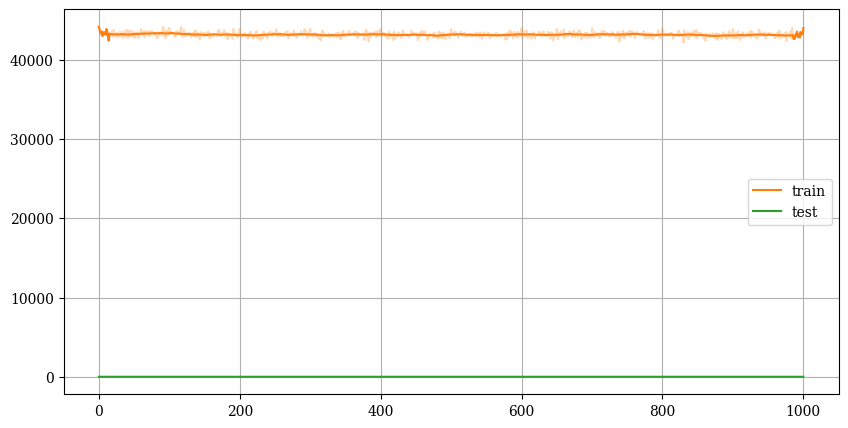

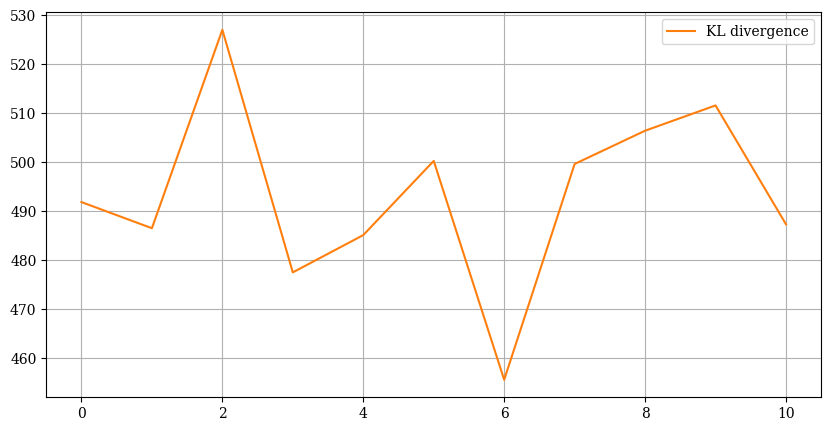

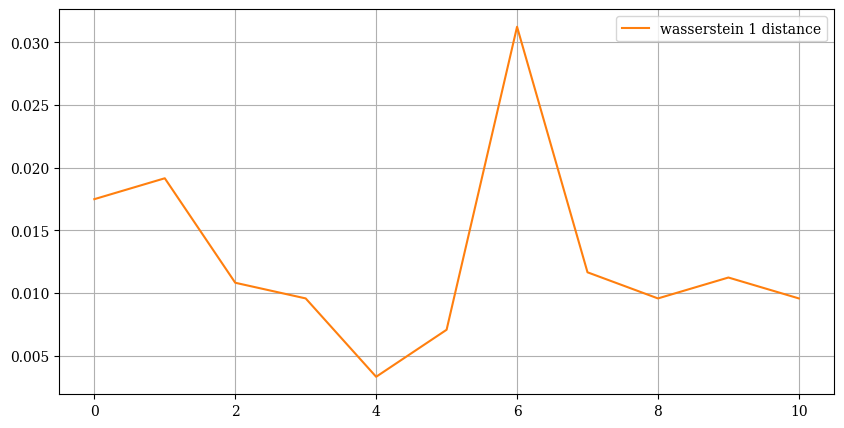

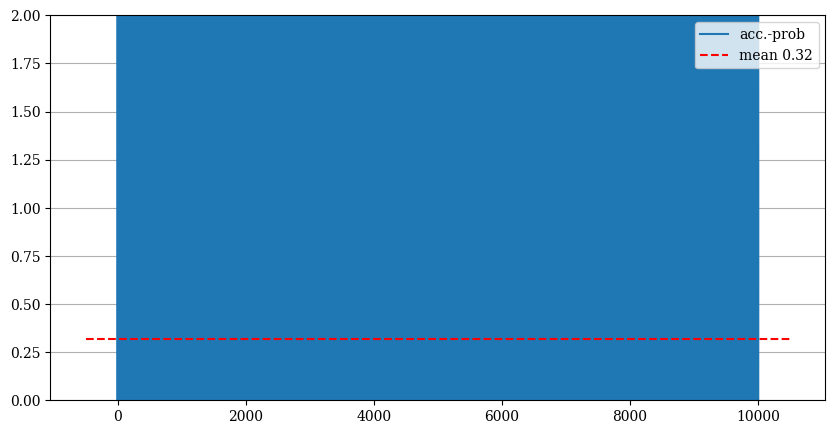

In [27]:
if MCMC:
    with open(m_list_dir + f'AdamMCMC_losses_{ep}.npy', 'rb') as f:
        loss_hist = np.load(f)
    with open(m_list_dir + f'AdamMCMC_acc_{ep}.npy', 'rb') as f:
        acc_hist = np.load(f)
    with open(m_list_dir + f'loss_hist_{ep}.npy', 'rb') as f:
        loss_hist = np.load(f)
    with open(m_list_dir + f'loss_hist_test_{ep}.npy', 'rb') as f:
        loss_hist_test =  np.load(f)
    with open(m_list_dir + f'loss_hist_test_ep_{ep}.npy', 'rb') as f:
        loss_hist_test_ep =  np.load(f)
    with open(m_list_dir + f'kl_div_hist_{ep}.npy', 'rb') as f:
        kl_div_hist =  np.load(f)
    with open(m_list_dir + f'w1_hist_{ep}.npy', 'rb') as f:
        w1_hist =  np.load(f)
        
    # Plot loss
    plt.figure(figsize=(10, 5))
    plt.plot(smooth(loss_hist,1), color = 'C1', alpha = 0.3)
    plt.plot(smooth(loss_hist,31), color = 'C1', label = 'train')

    plt.plot(loss_hist_test_ep, loss_hist_test, color = 'C2', label = 'test')

    plt.grid()
    plt.legend()
    #plt.xlim(0,12500)
    #plt.ylim(3,8)
    img_outfile = m_list_dir + f"image_ep{ep}_loss.pdf"
    plt.savefig(img_outfile)
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(kl_div_hist, color = 'C1', label = 'KL divergence')
    plt.grid()
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(w1_hist, color = 'C1', label = 'wasserstein 1 distance')
    plt.grid()
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(acc_hist, label = 'acc.-prob')
    plt.hlines(np.clip(acc_hist, 0, 1).mean(), *plt.xlim(), color = 'red', linestyles='--', label = f'mean {np.clip(acc_hist, 0, 1).mean():3.2}')
    plt.grid()
    plt.ylim(0,2)
    plt.legend()
    plt.savefig(m_list_dir+f"image_ep{ep}_acc.pdf")
    plt.show()

In [28]:
r_test = 4.

donut_args['r_mean'] = r_test
sampler = multidim_sampler(data_dim, "donut_gamma", save_path = data_path, **donut_args)

n_quantile = 5
data_true = cart_to_nsphere(sampler.sample_data(10_000_000)[0])
quant_list = quantiles(data_true, n_quantile, verbose = False)
quant_list = (np.concatenate((np.asarray([-100]), np.asarray(quant_list[0]), np.asarray([100])), 0),
            np.concatenate((np.asarray([0]), np.asarray(quant_list[1]), np.asarray([2*np.pi])), 0))

data_true = cart_to_nsphere(sampler.sample_data(10_000_000)[0])
quantvals_true = quantile_values_via_hist(quant_list, data_true)

/beegfs/desy/user/bierings/Bayesiamplify/./src/dataloader.py:7: RuntimeWarning: divide by zero encountered in divide
  out = np.arctan(1/x)


In [29]:
bins=np.linspace(-2*r_test,2*r_test,50)

z = torch.randn(10_000_000, data_dim).to(device)
batch_size_sample = 1_000_000
c = r_test*torch.ones((len(z),1)).to(device)
n_stat_epis = 10 if approximate_gaussian_inference else MCMC_samples

quantvals = []
hist_generated = np.zeros((n_stat_epis, len(bins)-1, len(bins)-1))

for n in tqdm(range(n_stat_epis)):
    if approximate_gaussian_inference:
        for layer in model.modules():
            if isinstance(layer, LinearFlipout):
                layer.auto_sample = False 
                layer.sample_weights()
    elif MCMC:
        model.load_state_dict(torch.load(m_list_dir + f"AdamMCMC_model_{n*save_every}.pth"))

    generated_data = np.zeros((len(z), data_dim)) 
    for n_z in range(len(z)//batch_size_sample):
        z_sample_temp = z[n_z*batch_size_sample:(n_z+1)*batch_size_sample]
        c_sample_temp = c[n_z*batch_size_sample:(n_z+1)*batch_size_sample]
        generated_data[n_z*batch_size_sample:(n_z+1)*batch_size_sample] = model.decode(z_sample_temp, cond=c_sample_temp).detach().cpu().numpy()
    
    quantvals.append(quantile_values_via_hist(quant_list, cart_to_nsphere(generated_data)))
    hist_generated[n], xedges, yedges = np.histogram2d(generated_data[:,0], generated_data[:,1], bins=bins)
    del generated_data
    
quantvals = np.array(quantvals)

100%|██████████| 10/10 [04:34<00:00, 27.45s/it]


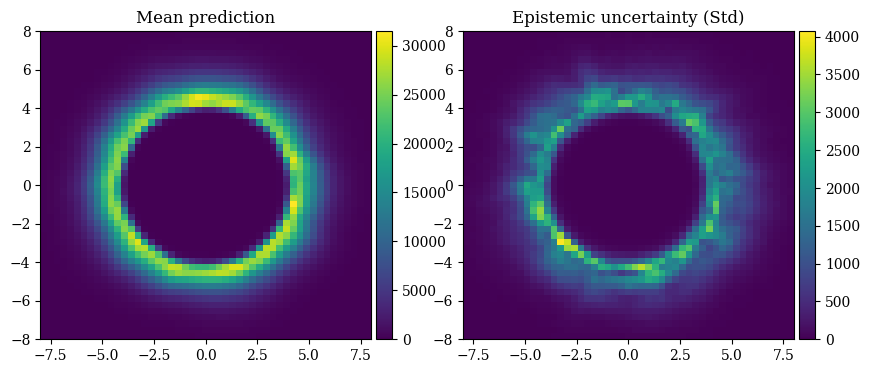

/tmp/ipykernel_19014/3455042127.py:36: RuntimeWarning: invalid value encountered in divide
  im = ax.pcolormesh(X, Y, hist_generated_std**2/hist_generated_mean)


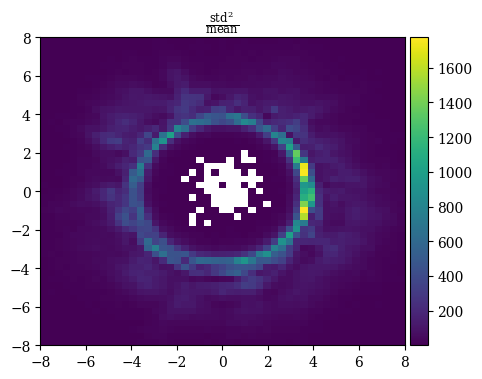

In [30]:
#plot relative uncertainty !!!!!!!

X, Y = np.meshgrid(xedges, yedges)
fig, ax = plt.subplots(1,2, figsize=(10,4))

cax = []
for a in ax:
    divider = make_axes_locatable(a)
    cax.append(divider.append_axes('right', size='5%', pad=0.05))

# H,_,_ = np.histogram2d(full_data[:,0], full_data[:,1], bins=bins)
# im = ax[0].pcolormesh(X, Y, H.T) 
# ax[0].set_title('Train Data')
# fig.colorbar(im, cax=cax[0], orientation='vertical')

hist_generated_mean = hist_generated.mean(0).T
im = ax[0].pcolormesh(X, Y, hist_generated_mean) 
ax[0].set_title('Mean prediction')
fig.colorbar(im, cax=cax[0], orientation='vertical')

hist_generated_std = hist_generated.std(0).T
im = ax[1].pcolormesh(X, Y, hist_generated_std) 
ax[1].set_title('Epistemic uncertainty (Std)')
fig.colorbar(im, cax=cax[1], orientation='vertical')
img_outfile = m_list_dir + f"image_ep{ep}_prediction.pdf"
plt.savefig(img_outfile)
plt.show()

#new plot to test poisson error property

fig, ax = plt.subplots(1,1, figsize=(5,4))

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)

im = ax.pcolormesh(X, Y, hist_generated_std**2/hist_generated_mean) 
ax.set_title(r'$\frac{\mathrm{std}^2}{\mathrm{mean}}$')
fig.colorbar(im, cax=cax, orientation='vertical')
img_outfile = m_list_dir + f"image_ep{ep}_poisson.pdf"
plt.savefig(img_outfile)

In [31]:
bins_data = quant_list

number_pixels = 800 #2000 increase for final plots

quantile_mean_data = (quantvals.mean(0)-quantvals_true)#/quantvals_true
quantile_mean_img_data_OG = np.zeros((number_pixels, number_pixels))
quantile_std_data = (quantvals.mean(0)-quantvals_true)/quantvals.std(0)
quantile_std_img_data_OG = np.zeros((number_pixels, number_pixels))

E_min = -6 #2*r_test
E_max = 6 #2*r_test

for x in range(0, number_pixels):
    for y in range(0, number_pixels):
        X = ((x + 0.0)*(E_max-E_min))/number_pixels+E_min
        Y = ((y + 0.0)*(E_max-E_min))/number_pixels+E_min
        r  = np.sqrt(X**2 + Y**2)
        phi = np.arctan2(X,Y) #+ np.pi
        phi = phi + 2*np.pi*(phi<0).astype(int)
                
        hist_data_temp = np.array([[r,phi]])
        quant_hist_temp, edges = np.histogramdd(sample = hist_data_temp, bins = bins_data, range = None)

        quantile_mean_img_data_OG[x,y] = np.sum(quant_hist_temp*quantile_mean_data)
        quantile_std_img_data_OG[x,y] = np.sum(quant_hist_temp*np.abs(quantile_std_data))

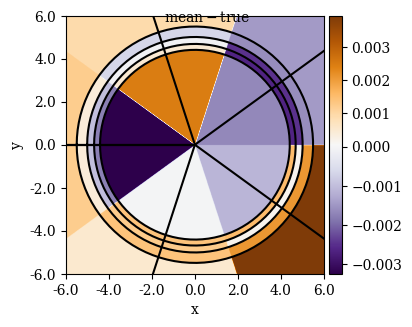

In [32]:
import matplotlib as mpl
import matplotlib.colors as clr

quantile_GAN_img_data = np.copy(quantile_mean_img_data_OG)
quantile_sample_img_data = np.copy(quantile_std_img_data_OG)

font_s = None #25

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = clr.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

colors_pos = plt.cm.RdBu_r(np.linspace(0.5, 1, 256))
colors_neg = plt.cm.RdBu_r(np.linspace(1, 0.5, 256))
all_colors = np.vstack((colors_neg, colors_pos))
col_map = clr.LinearSegmentedColormap.from_list('col_map', plt.cm.PuOr(np.linspace(1, 0, 256)))
    #all_colors)

# make the norm:  Note the center is offset so that the land has more
# dynamic range:
divnorm = clr.TwoSlopeNorm(vmin=quantile_GAN_img_data.min(), vcenter=quantile_GAN_img_data.mean(), vmax=quantile_GAN_img_data.max())
    
figSide = plt.figure(figsize=(3.7,3))
axS1 = figSide.add_subplot(1,1,1)
pStra = axS1.imshow(quantile_GAN_img_data, norm=divnorm, cmap=col_map)

axS1.set_xticks(np.arange(0, number_pixels+1, number_pixels/6))
axS1.set_xticklabels(np.around(np.linspace(E_min, E_max, 7),2))
axS1.set_yticks(np.arange(0, number_pixels+1, number_pixels/6))
axS1.set_yticklabels(np.around(np.linspace(E_min, E_max, 7),2))
axS1.tick_params(labelsize=font_s) 

divider = make_axes_locatable(axS1)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(pStra, cax=cax)
cbar.ax.tick_params(labelsize=font_s) 
#collabels = np.concatenate((np.linspace(-1*vmax, vcenter, 3)/vmax + vcenter_OG,
#                            np.linspace(vcenter, vmax, 3)[1:]     + vcenter_OG))
#cbar.ax.set_yticklabels(collabels) 

#figSide.colorbar(pStra)

for r in quant_list[0]:
    a = np.linspace(0, 2*np.pi, 100)
    x = -r*np.cos(a)*number_pixels/(E_max-E_min) + number_pixels/2
    y = r*np.sin(a)*number_pixels/(E_max-E_min) + number_pixels/2
    axS1.plot(x,y, color='k')

for p in quant_list[1]:
    r = np.linspace(0, 20, 20)
    
    x = -r*np.cos(p)*number_pixels/(E_max-E_min) + number_pixels/2
    y = r*np.sin(p)*number_pixels/(E_max-E_min) + number_pixels/2
    axS1.plot(x,y, color='k')   

x = r*np.cos(np.pi)*number_pixels/(E_max-E_min) + number_pixels/2
y = r*np.sin(np.pi)*number_pixels/(E_max-E_min) + number_pixels/2
axS1.plot(x,y, color='k', label='quantiles')   

axS1.set_xlim([0, number_pixels])
axS1.set_ylim([0, number_pixels])

#axS1.legend()
axS1.set_xlabel('x', fontsize=font_s)
axS1.set_ylabel('y', fontsize=font_s)
figSide.suptitle(r'$\mathrm{mean}-\mathrm{true}$' , fontsize=font_s)
plt.subplots_adjust(left=0.1, right=0.88, top=0.96, bottom=0.10)
        
img_outfile = m_list_dir + f"image_ep{ep}_mean_radial.pdf"
plt.savefig(img_outfile)

##############################################################################################################################################################################################
##############################################################################################################################################################################################
##############################################################################################################################################################################################

divnorm = clr.TwoSlopeNorm(vmin=quantile_sample_img_data.min(), vcenter=quantile_sample_img_data.mean(), vmax=quantile_sample_img_data.max())
col_map = clr.LinearSegmentedColormap.from_list('col_map',  plt.cm.RdBu(np.linspace(1, 0, 256)))

#figSide = plt.figure(figsize=(3.5,3))
axS1 = ax_quantiles[2] #figSide.add_subplot(1,1,1)
pStra = axS1.imshow(quantile_sample_img_data, norm=divnorm, cmap=col_map)

axS1.set_xticks(np.arange(0, number_pixels+1, number_pixels/4))
axS1.set_xticklabels(np.around(np.linspace(E_min, E_max, 5),2))
axS1.set_yticks(np.arange(0, number_pixels+1, number_pixels/4))
axS1.set_yticklabels(np.around(np.linspace(E_min, E_max, 5),2))
axS1.tick_params(labelsize=font_s) 

divider = make_axes_locatable(axS1)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(pStra, cax=cax, ticks = [0.1,0.5,1,1.5,2.0])
cax.tick_params(labelsize=font_s) 

for r in quant_list[0]:
    a = np.linspace(0, 2*np.pi, 100)
    x = r*np.cos(a)*number_pixels/(E_max-E_min) + number_pixels/2
    y = r*np.sin(a)*number_pixels/(E_max-E_min) + number_pixels/2
    axS1.plot(x,y, color='k', linewidth = 1.)

for p in quant_list[1]:
    r = np.linspace(0, 20, 20)
    x = r*np.cos(p)*number_pixels/(E_max-E_min) + number_pixels/2
    y = r*np.sin(p)*number_pixels/(E_max-E_min) + number_pixels/2
    axS1.plot(x,y, color='k', linewidth = 1.)   

# x = -r*np.cos(np.pi)*number_pixels/(E_max-E_min) + number_pixels/2
# y = r*np.sin(np.pi)*number_pixels/(E_max-E_min) + number_pixels/2
# axS1.plot(x,y, color='k', label='quantiles', linewidth = 1.)   

axS1.set_xlim([0, number_pixels])
axS1.set_ylim([0, number_pixels])

#axS1.legend()
axS1.set_xlabel('x', fontsize=font_s)
axS1.set_ylabel('y', fontsize=font_s)
axS1.set_title(r'$\frac{\mathrm{mean}-\mathrm{true}}{\sigma_\mathrm{epis}}$' , fontsize=font_s)
#plt.subplots_adjust(left=0.1, right=0.88, top=0.96, bottom=0.10)
fig_quantiles.tight_layout()

#img_outfile = f"./figs/01_3_image_ep{ep}_sigma_radial.pdf"
#plt.savefig(img_outfile)

img_outfile = f"./figs/01_data_and_quantiles.pdf"
fig_quantiles.savefig(img_outfile)

In [35]:
bins_data = quant_list

number_pixels = 800 #2000 increase for final plots

quantile_mean_data = (quantvals.mean(0)-quantvals_true)/quantvals_true
quantile_mean_img_data_OG = np.zeros((number_pixels, number_pixels))
quantile_std_data = quantvals.std(0)
quantile_std_img_data_OG = np.zeros((number_pixels, number_pixels))

E_min = -2*r_test
E_max = 2*r_test

for x in range(0, number_pixels):
    for y in range(0, number_pixels):
        X = ((x + 0.0)*(E_max-E_min))/number_pixels+E_min
        Y = ((y + 0.0)*(E_max-E_min))/number_pixels+E_min
        r  = np.sqrt(X**2 + Y**2)
        phi = np.arctan2(X,Y) #+ np.pi
        phi = phi + 2*np.pi*(phi<0).astype(int)
                
        hist_data_temp = np.array([[r,phi]])
        quant_hist_temp, edges = np.histogramdd(sample = hist_data_temp, bins = bins_data, range = None)

        quantile_mean_img_data_OG[x,y] = np.sum(quant_hist_temp*quantile_mean_data)
        quantile_std_img_data_OG[x,y] = np.sum(quant_hist_temp*np.abs(quantile_std_data))

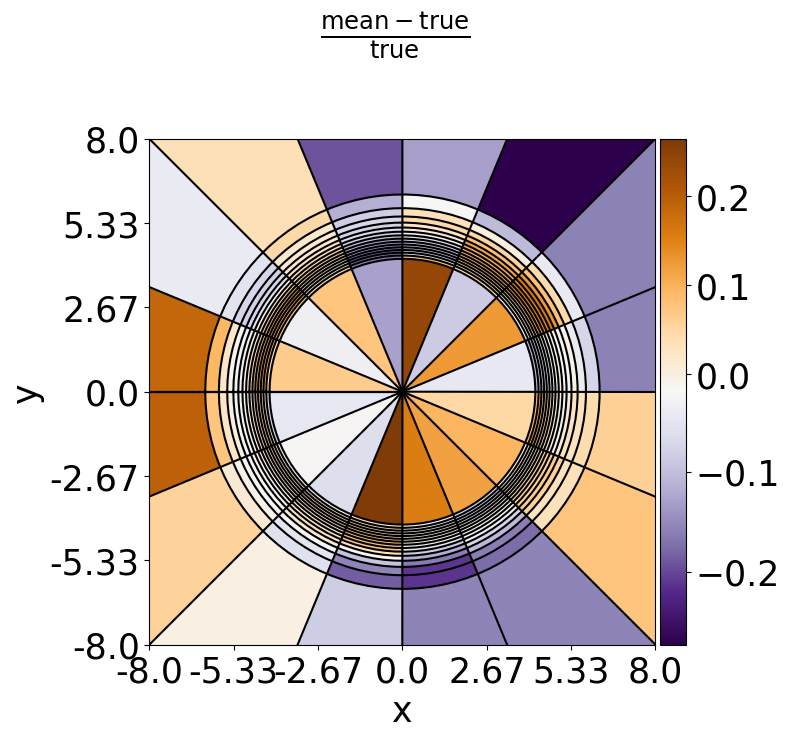

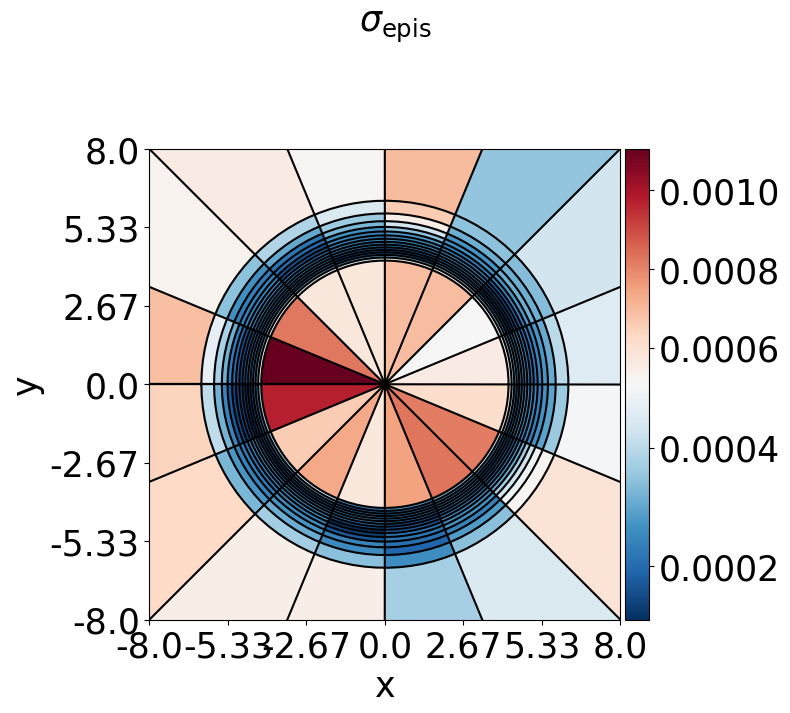

In [36]:
import matplotlib as mpl
import matplotlib.colors as clr

quantile_GAN_img_data = np.copy(quantile_mean_img_data_OG)
quantile_sample_img_data = np.copy(quantile_std_img_data_OG)

font_s = 25

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = clr.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

colors_pos = plt.cm.RdBu_r(np.linspace(0.5, 1, 256))
colors_neg = plt.cm.RdBu_r(np.linspace(1, 0.5, 256))
all_colors = np.vstack((colors_neg, colors_pos))
col_map = clr.LinearSegmentedColormap.from_list('col_map', plt.cm.PuOr(np.linspace(1, 0, 256)))
    #all_colors)

# make the norm:  Note the center is offset so that the land has more
# dynamic range:
divnorm = clr.TwoSlopeNorm(vmin=quantile_GAN_img_data.min(), vcenter=quantile_GAN_img_data.mean(), vmax=quantile_GAN_img_data.max())
    
figSide = plt.figure(figsize=(8,8))
axS1 = figSide.add_subplot(1,1,1)
pStra = axS1.imshow(quantile_GAN_img_data, norm=divnorm, cmap=col_map)

axS1.set_xticks(np.arange(0, number_pixels+1, number_pixels/6))
axS1.set_xticklabels(np.around(np.linspace(E_min, E_max, 7),2))
axS1.set_yticks(np.arange(0, number_pixels+1, number_pixels/6))
axS1.set_yticklabels(np.around(np.linspace(E_min, E_max, 7),2))
axS1.tick_params(labelsize=font_s) 

divider = make_axes_locatable(axS1)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(pStra, cax=cax)
cbar.ax.tick_params(labelsize=font_s) 
#collabels = np.concatenate((np.linspace(-1*vmax, vcenter, 3)/vmax + vcenter_OG,
#                            np.linspace(vcenter, vmax, 3)[1:]     + vcenter_OG))
#cbar.ax.set_yticklabels(collabels) 

#figSide.colorbar(pStra)

for r in quant_list[0]:
    a = np.linspace(0, 2*np.pi, 100)
    x = -r*np.cos(a)*number_pixels/(E_max-E_min) + number_pixels/2
    y = r*np.sin(a)*number_pixels/(E_max-E_min) + number_pixels/2
    axS1.plot(x,y, color='k')

for p in quant_list[1]:
    r = np.linspace(0, 20, 20)
    x = -r*np.cos(p)*number_pixels/(E_max-E_min) + number_pixels/2
    y = r*np.sin(p)*number_pixels/(E_max-E_min) + number_pixels/2
    axS1.plot(x,y, color='k')   

x = r*np.cos(np.pi)*number_pixels/(E_max-E_min) + number_pixels/2
y = r*np.sin(np.pi)*number_pixels/(E_max-E_min) + number_pixels/2
axS1.plot(x,y, color='k', label='quantiles')   

axS1.set_xlim([0, number_pixels])
axS1.set_ylim([0, number_pixels])

#axS1.legend()
axS1.set_xlabel('x', fontsize=font_s)
axS1.set_ylabel('y', fontsize=font_s)
figSide.suptitle(r'$\frac{\mathrm{mean}-\mathrm{true}}{\mathrm{true}}$' , fontsize=font_s)
#plt.subplots_adjust(left=0.1, right=0.88, top=0.96, bottom=0.10)
plt.tight_layout()
img_outfile = m_list_dir + f"image_ep{ep}_mean_rel_radial.pdf"
plt.savefig(img_outfile)

##############################################################################################################################################################################################
##############################################################################################################################################################################################
##############################################################################################################################################################################################

divnorm = clr.TwoSlopeNorm(vmin=quantile_sample_img_data.min(), vcenter=quantile_sample_img_data.mean(), vmax=quantile_sample_img_data.max())
col_map = clr.LinearSegmentedColormap.from_list('col_map',  plt.cm.RdBu(np.linspace(1, 0, 256)))

figSide = plt.figure(figsize=(8,8))
axS1 = figSide.add_subplot(1,1,1)
pStra = axS1.imshow(quantile_sample_img_data, norm=divnorm, cmap=col_map)

axS1.set_xticks(np.arange(0, number_pixels+1, number_pixels/6))
axS1.set_xticklabels(np.around(np.linspace(E_min, E_max, 7),2))
axS1.set_yticks(np.arange(0, number_pixels+1, number_pixels/6))
axS1.set_yticklabels(np.around(np.linspace(E_min, E_max, 7),2))
axS1.tick_params(labelsize=font_s) 

divider = make_axes_locatable(axS1)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(pStra, cax=cax)
cax.tick_params(labelsize=font_s) 

for r in quant_list[0]:
    a = np.linspace(0, 2*np.pi, 100)
    x = -r*np.cos(a)*number_pixels/(E_max-E_min) + number_pixels/2
    y = r*np.sin(a)*number_pixels/(E_max-E_min) + number_pixels/2
    axS1.plot(x,y, color='k')

for p in quant_list[1]:
    r = np.linspace(0, 20, 20)
    x = -r*np.cos(p)*number_pixels/(E_max-E_min) + number_pixels/2
    y = r*np.sin(p)*number_pixels/(E_max-E_min) + number_pixels/2
    axS1.plot(x,y, color='k')   

x = r*np.cos(np.pi)*number_pixels/(E_max-E_min) + number_pixels/2
y = r*np.sin(np.pi)*number_pixels/(E_max-E_min) + number_pixels/2
axS1.plot(x,y, color='k', label='quantiles')   

axS1.set_xlim([0, number_pixels])
axS1.set_ylim([0, number_pixels])

#axS1.legend()
axS1.set_xlabel('x', fontsize=font_s)
axS1.set_ylabel('y', fontsize=font_s)
figSide.suptitle(r'$\sigma_\mathrm{epis}$' , fontsize=font_s)
#plt.subplots_adjust(left=0.1, right=0.88, top=0.96, bottom=0.10)
plt.tight_layout()
img_outfile = m_list_dir + f"image_ep{ep}_sigma_abs_radial.pdf"
plt.savefig(img_outfile)

In [ ]:
# introduce batches in quant eval scipt as well

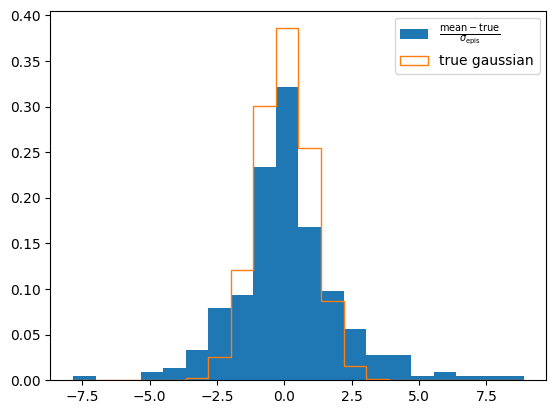

In [ ]:
dat_plt = (quantvals.mean(0)-quantvals_true)/quantvals.std(0)
_,b,_, = plt.hist(dat_plt.flatten(), density = True, label = r'$\frac{\mathrm{mean}-\mathrm{true}}{\sigma_\mathrm{epis}}$', bins = 20)
_ = plt.hist(np.random.normal(0,1,1000000), density = True, bins = b, histtype='step', label = 'true gaussian')
plt.legend()
img_outfile = m_list_dir + f"image_ep{ep}_calibration.pdf"
plt.savefig(img_outfile)

In [ ]:
n_est_sum = np.sum(np.mean(quantvals,0)**2/np.std(quantvals,0)**2)
#n_est = np.mean(np.std(quantvals*len(z),0)**2) This way the amplification would depent on the number of samples

print(f'amplification ist predicted to be {n_est_sum/(quantvals.shape[1]*quantvals.shape[2]):2.3}/{n_samples/(quantvals.shape[1]*quantvals.shape[2]):2.3} = {1/n_samples*n_est_sum:2.4}')

amplification ist predicted to be 1.17e+03/39.1 = 30.08


In [13]:
r_test = 4.

donut_args['r_mean'] = r_test
sampler = multidim_sampler(data_dim, "donut_gamma", save_path = data_path, **donut_args)

n_quantile = 250
quant_list = [np.linspace(3.5,5.0,250), np.linspace(0,2*np.pi,50)]

data_true = cart_to_nsphere(sampler.sample_data(10_000_000)[0])
quantvals_true = quantile_values_via_hist(quant_list, data_true)

/beegfs/desy/user/bierings/Bayesiamplify/./src/dataloader.py:7: RuntimeWarning: divide by zero encountered in divide
  out = np.arctan(1/x)


In [14]:
bins=np.linspace(-2*r_test,2*r_test,50)

z = torch.randn(10_000_000, data_dim).to(device)
batch_size_sample = 1_000_000
c = r_test*torch.ones((len(z),1)).to(device)
n_stat_epis = 10 if approximate_gaussian_inference else MCMC_samples

quantvals = []

for n in tqdm(range(n_stat_epis)):
    if approximate_gaussian_inference:
        for layer in model.modules():
            if isinstance(layer, LinearFlipout):
                layer.auto_sample = False 
                layer.sample_weights()
    elif MCMC:
        model.load_state_dict(torch.load(m_list_dir + f"AdamMCMC_model_{n*save_every}.pth"))

    generated_data = np.zeros((len(z), data_dim)) 
    for n_z in range(len(z)//batch_size_sample):
        z_sample_temp = z[n_z*batch_size_sample:(n_z+1)*batch_size_sample]
        c_sample_temp = c[n_z*batch_size_sample:(n_z+1)*batch_size_sample]
        generated_data[n_z*batch_size_sample:(n_z+1)*batch_size_sample] = model.decode(z_sample_temp, cond=c_sample_temp).detach().cpu().numpy()
    
    quantvals.append(quantile_values_via_hist(quant_list, cart_to_nsphere(generated_data)))
    del generated_data
    
quantvals = np.array(quantvals)

 90%|█████████ | 9/10 [14:08<01:32, 92.91s/it]

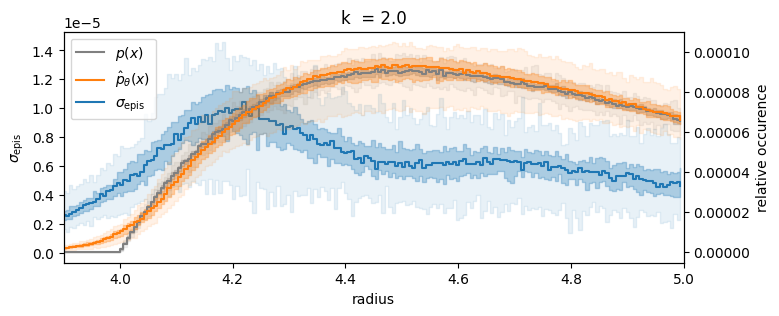

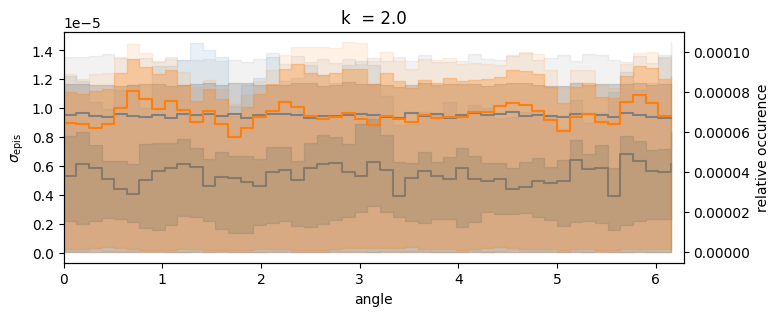

In [20]:
dat_plt = quantvals.std(0)
dat_plt_pred = quantvals.mean(0)

c = 'C0'
c1 = 'grey'
c2 = 'C1'

linestyle_min_max = ':'
fig1,ax1 = plt.subplots(1,1,figsize = (8,3), sharey=True)
fig2,ax2 = plt.subplots(1,1,figsize = (8,3), sharey=True)

ax = [ax1, ax2]

### data ###

dat_true, _ = np.histogramdd(sample = data_true, bins = quant_list, weights = None, range = None)
dat_true =  dat_true/data_true.shape[0]

ax_add0 = ax[0].twinx()
ax_add1 = ax[1].twinx()
ax_add0.set_ylabel(r'relative occurence')
ax_add1.set_ylabel(r'relative occurence')

data_plot = ax_add0.step(quant_list[0][:-1], np.median(dat_true, 1), color = c1, where = 'post')
ax_add1.step(quant_list[1][:-1], np.median(dat_true, 0), color = c1, where = 'post')

ax_add0.fill_between(quant_list[0][:-1], np.min(dat_true, 1), np.max(dat_true, 1), color = c1, step = 'post', alpha = 0.1)
ax_add1.fill_between(quant_list[1][:-1], np.min(dat_true, 0), np.max(dat_true, 0), color = c1, step = 'post', alpha = 0.1)

ax_add0.fill_between(quant_list[0][:-1], np.quantile(dat_true, 0.25, 1), np.quantile(dat_true, 0.75, 1), color = c1, step = 'post', alpha = 0.3)
ax_add1.fill_between(quant_list[1][:-1], np.quantile(dat_true, 0.25, 0), np.quantile(dat_true, 0.75, 0), color = c1, step = 'post', alpha = 0.3)

### sigma ###

sigma_plot = ax[0].step(quant_list[0][:-1], np.median(dat_plt, 1), color = c, where = 'post')
ax[1].step(quant_list[1][:-1], np.median(dat_plt, 0), color = c, where = 'post')

ax[0].fill_between(quant_list[0][:-1], np.min(dat_plt, 1), np.max(dat_plt, 1), color = c, step = 'post', alpha = 0.1)
ax[1].fill_between(quant_list[1][:-1], np.min(dat_plt, 0), np.max(dat_plt, 0), color = c, step = 'post', alpha = 0.1)

ax[0].fill_between(quant_list[0][:-1], np.quantile(dat_plt, 0.25, 1), np.quantile(dat_plt, 0.75, 1), color = c, step = 'post', alpha = 0.3)
ax[1].fill_between(quant_list[1][:-1], np.quantile(dat_plt, 0.25, 0), np.quantile(dat_plt, 0.75, 0), color = c, step = 'post', alpha = 0.3)

### mean prediciton ###

mean_plot = ax_add0.step(quant_list[0][:-1], np.median(dat_plt_pred, 1), color = c2, where = 'post')
ax_add1.step(quant_list[1][:-1], np.median(dat_plt_pred, 0), color = c2, where = 'post')

ax_add0.fill_between(quant_list[0][:-1], np.min(dat_plt_pred, 1), np.max(dat_plt_pred, 1), color = c2, step = 'post', alpha = 0.1)
ax_add1.fill_between(quant_list[1][:-1], np.min(dat_plt_pred, 0), np.max(dat_plt_pred, 0), color = c2, step = 'post', alpha = 0.1)

ax_add0.fill_between(quant_list[0][:-1], np.quantile(dat_plt_pred, 0.25, 1), np.quantile(dat_plt_pred, 0.75, 1), color = c2, step = 'post', alpha = 0.3)
ax_add1.fill_between(quant_list[1][:-1], np.quantile(dat_plt_pred, 0.25, 0), np.quantile(dat_plt_pred, 0.75, 0), color = c2, step = 'post', alpha = 0.3)

ax[0].set_xlim(3.9,5.0)#4.5)
ax[1].set_xlim(0, 2*np.pi)

ax[0].set_xlabel('radius')
ax[1].set_xlabel('angle')
ax[0].set_ylabel(r'$\sigma_\mathrm{epis}$')
ax[1].set_ylabel(r'$\sigma_\mathrm{epis}$')

ax[0].set_title(f'k  = {donut_args["gamma_scale"]}')
ax[1].set_title(f'k  = {donut_args["gamma_scale"]}')

ax[0].legend([data_plot[0], mean_plot[0], sigma_plot[0]], [r'$p(x)$', r'$\hat{p}_\theta(x)$', r'$\sigma_\mathrm{epis}$'], loc = 'upper left')
img_outfile = m_list_dir + f"image_ep{ep}_sigma_over_radius.pdf"
fig1.savefig(img_outfile)
img_outfile = m_list_dir + f"image_ep{ep}_sigma_over_angle.pdf"
fig2.savefig(img_outfile)